In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp "/content/drive/My Drive/Histopathology data/test2classes.zip" "test2classes.zip"
!cp "/content/drive/My Drive/Histopathology data/Inception2sgd.pth" "Inception2sgd.pth"

In [ ]:
!unzip -q test2classes.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # 
batch_size_test = 5 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets

test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


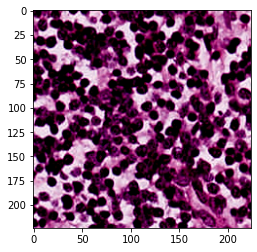

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class BasicConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

#same naive inception module
class InceptionA(nn.Module):

    def __init__(self, input_channels, pool_features):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 64, kernel_size=1)

        self.branch5x5 = nn.Sequential(
            BasicConv2d(input_channels, 48, kernel_size=1),
            BasicConv2d(48, 64, kernel_size=5, padding=2)
        )

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, padding=1)
        )

        self.branchpool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, pool_features, kernel_size=3, padding=1)
        )

    def forward(self, x):

        #x -> 1x1(same)
        branch1x1 = self.branch1x1(x)

        #x -> 1x1 -> 5x5(same)
        branch5x5 = self.branch5x5(x)
        #branch5x5 = self.branch5x5_2(branch5x5)

        #x -> 1x1 -> 3x3 -> 3x3(same)
        branch3x3 = self.branch3x3(x)

        #x -> pool -> 1x1(same)
        branchpool = self.branchpool(x)

        outputs = [branch1x1, branch5x5, branch3x3, branchpool]

        return torch.cat(outputs, 1)

#downsample
#Factorization into smaller convolutions
class InceptionB(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = BasicConv2d(input_channels, 384, kernel_size=3, stride=2)

        self.branch3x3stack = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=2)
        )

        self.branchpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        #x - > 3x3(downsample)
        branch3x3 = self.branch3x3(x)

        #x -> 3x3 -> 3x3(downsample)
        branch3x3stack = self.branch3x3stack(x)

        #x -> avgpool(downsample)
        branchpool = self.branchpool(x)

        #"""We can use two parallel stride 2 blocks: P and C. P is a pooling
        #layer (either average or maximum pooling) the activation, both of
        #them are stride 2 the filter banks of which are concatenated as in
        #figure 10."""
        outputs = [branch3x3, branch3x3stack, branchpool]

        return torch.cat(outputs, 1)

#Factorizing Convolutions with Large Filter Size
class InceptionC(nn.Module):
    def __init__(self, input_channels, channels_7x7):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 192, kernel_size=1)

        c7 = channels_7x7

        #In theory, we could go even further and argue that one can replace any n × n
        #convolution by a 1 × n convolution followed by a n × 1 convolution and the
        #computational cost saving increases dramatically as n grows (see figure 6).
        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch7x7stack = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1),
        )

    def forward(self, x):

        #x -> 1x1(same)
        branch1x1 = self.branch1x1(x)

        #x -> 1layer 1*7 and 7*1 (same)
        branch7x7 = self.branch7x7(x)

        #x-> 2layer 1*7 and 7*1(same)
        branch7x7stack = self.branch7x7stack(x)

        #x-> avgpool (same)
        branchpool = self.branch_pool(x)

        outputs = [branch1x1, branch7x7, branch7x7stack, branchpool]

        return torch.cat(outputs, 1)

class InceptionD(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 320, kernel_size=3, stride=2)
        )

        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(192, 192, kernel_size=3, stride=2)
        )

        self.branchpool = nn.AvgPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        #x -> 1x1 -> 3x3(downsample)
        branch3x3 = self.branch3x3(x)

        #x -> 1x1 -> 1x7 -> 7x1 -> 3x3 (downsample)
        branch7x7 = self.branch7x7(x)

        #x -> avgpool (downsample)
        branchpool = self.branchpool(x)

        outputs = [branch3x3, branch7x7, branchpool]

        return torch.cat(outputs, 1)


#same
class InceptionE(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(input_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3stack_1 = BasicConv2d(input_channels, 448, kernel_size=1)
        self.branch3x3stack_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3stack_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3stack_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1)
        )

    def forward(self, x):

        #x -> 1x1 (same)
        branch1x1 = self.branch1x1(x)

        # x -> 1x1 -> 3x1
        # x -> 1x1 -> 1x3
        # concatenate(3x1, 1x3)
        #"""7. Inception modules with expanded the filter bank outputs.
        #This architecture is used on the coarsest (8 × 8) grids to promote
        #high dimensional representations, as suggested by principle
        #2 of Section 2."""
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3)
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        # x -> 1x1 -> 3x3 -> 1x3
        # x -> 1x1 -> 3x3 -> 3x1
        #concatenate(1x3, 3x1)
        branch3x3stack = self.branch3x3stack_1(x)
        branch3x3stack = self.branch3x3stack_2(branch3x3stack)
        branch3x3stack = [
            self.branch3x3stack_3a(branch3x3stack),
            self.branch3x3stack_3b(branch3x3stack)
        ]
        branch3x3stack = torch.cat(branch3x3stack, 1)

        branchpool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch3x3stack, branchpool]

        return torch.cat(outputs, 1)

class InceptionV3(nn.Module):

    def __init__(self, num_classes=2):
        super().__init__()
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, padding=1)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3, padding=1)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)

        #naive inception module
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)

        #downsample
        self.Mixed_6a = InceptionB(288)

        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)

        #downsample
        self.Mixed_7a = InceptionD(768)

        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)

        #6*6 feature size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d()
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):

        #32 -> 30
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)

        #30 -> 30
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)

        #30 -> 14
        #Efficient Grid Size Reduction to avoid representation
        #bottleneck
        x = self.Mixed_6a(x)

        #14 -> 14
        #"""In practice, we have found that employing this factorization does not
        #work well on early layers, but it gives very good results on medium
        #grid-sizes (On m × m feature maps, where m ranges between 12 and 20).
        #On that level, very good results can be achieved by using 1 × 7 convolutions
        #followed by 7 × 1 convolutions."""
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)

        #14 -> 6
        #Efficient Grid Size Reduction
        x = self.Mixed_7a(x)

        #6 -> 6
        #We are using this solution only on the coarsest grid,
        #since that is the place where producing high dimensional
        #sparse representation is the most critical as the ratio of
        #local processing (by 1 × 1 convolutions) is increased compared
        #to the spatial aggregation."""
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)

        #6 -> 1
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionV3()
model.load_state_dict(torch.load('Inception2sgd.pth', map_location=device))
model=model.to(device)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
   
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    y=[]
    y_pred=[]
    prob=[]
    for data, target in test_loader:
        t=target.tolist()
        y.append(t)
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        p=output.tolist()
        prob.append(p)     
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        m=pred.tolist()
        y_pred.append(m) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg, y,y_pred,prob

In [ ]:
import os.path
from os import path



stl,acct,y,y_pred,prob=test(model, device, test_loader)

print('average accuracy: ',acct)

Test: Average loss: 0.2097, Accuracy: 6898/7200 (95.81%)

average accuracy:  95.80555555555556


In [ ]:
flat_prob=[element for sublist in prob for element in sublist]
proba=np.array(flat_prob)
flatten_y = [element for sublist in y for element in sublist]
flatten_y_pred = [element for sublist in y_pred for element in sublist]
flatten_y_pred = [element for sublist in flatten_y_pred for element in sublist]

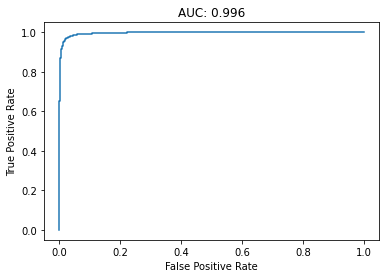

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_proba = proba[::,1]
fpr, tpr, thresholds = roc_curve(flatten_y, y_pred_proba)
auc = roc_auc_score(flatten_y, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('AUC: %.3f' % auc)
plt.show()
fpr=str(fpr)
tpr=str(tpr)

output_file = open('inc_fpr.txt', 'w')

for t in fpr:
    output_file.write(t)

output_file.close()


output_file = open('inc_tpr.txt', 'w')

for t in tpr:
    output_file.write(t)

output_file.close()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision=precision_score(flatten_y, flatten_y_pred)
precision=precision*100
print(precision)

97.43375174337517


In [ ]:
recall=recall_score(flatten_y, flatten_y_pred)
recall=recall*100
print(recall)

97.02777777777779


In [ ]:
f1=f1_score(flatten_y, flatten_y_pred)
f1=f1*100
print(f1)

97.2303409881698
